# Low resolution simulation feedbacks analyses
## fig11, B1, and B2

Original notebook: https://nbviewer.org/github/mickaellalande/PhD/blob/master/SCF_parameterizations/3_simulations/LR_simulation_feedbacks.ipynb

conda env: new `phd_v3` (in `envs/phd`)

## Simulations 

- NY07: LMDZORnudge-uvt-6h-10d-noBL-STD-NY07-2004-2008
- R01: LMDZORnudge-uvt-6h-10d-noBL-STD-R01-2004-2008
- SL12: LMDZORnudge-uvt-6h-10d-noBL-STD-SL12-2004-2008
- LA22: LMDZORnudge-uvt-6h-10d-noBL-STD-LA22-2004-2008

## Path to simulations

- Jean-Zay WORK: `/gpfsdswork/projects/rech/goe/ufz23bm/SCA_parameterization/modipsl/config/LMDZOR_v6/`
- Jean-Zay STORE: `/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR/DEVT/amip/`
- THREDDS: `/gpfsdsmnt/ipsl/dods/pub/ufz23bm/LMDZOR/DEVT/amip/`
- CICLAD: `/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/` 
- local: `~/Dropbox/data/IGCM_OUT/LMDZOR/DEVT/amip/`
- https://vesg.ipsl.upmc.fr/thredds/catalog/idris_work/ufz23bm/LMDZOR/DEVT/amip/

## Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
plot.rc['abc.style'] = '(a)' # for EGU journals (only abc in new proplot versions)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar

import sys
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

import warnings
warnings.filterwarnings("ignore")

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]
Virtual memory usage - total: 31 GB / available: 24 GB / percent used: 22.0 %


## Define paths

In [2]:
# root = '/thredds/idris/work/ufz23bm/LMDZOR/DEVT/amip/' # CICLAD
root = '/home/lalandmi/Dropbox/data/IGCM_OUT/LMDZOR/DEVT/amip/' # local

exp_NY07 = 'LMDZORnudge-uvt-6h-10d-noBL-STD-NY07-2004-2008'
exp_R01 = 'LMDZORnudge-uvt-6h-10d-noBL-STD-R01-2004-2008'
exp_SL12 = 'LMDZORnudge-uvt-6h-10d-noBL-STD-SL12-2004-2008'
exp_LA22 = 'LMDZORnudge-uvt-6h-10d-noBL-STD-LA22-2004-2008'

# 1 year spin-up
period = slice('2005', '2008')

## Load model data

In [3]:
SWdnSFC_NY07 = xr.open_dataset(root+exp_NY07+'/ATM/Analyse/TS_MO/'+exp_NY07+'_20040101_20081231_1M_SWdnSFC.nc').SWdnSFC.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
SWupSFC_NY07 = xr.open_dataset(root+exp_NY07+'/ATM/Analyse/TS_MO/'+exp_NY07+'_20040101_20081231_1M_SWupSFC.nc').SWupSFC.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
LWdnSFC_NY07 = xr.open_dataset(root+exp_NY07+'/ATM/Analyse/TS_MO/'+exp_NY07+'_20040101_20081231_1M_LWdnSFC.nc').LWdnSFC.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
LWupSFC_NY07 = xr.open_dataset(root+exp_NY07+'/ATM/Analyse/TS_MO/'+exp_NY07+'_20040101_20081231_1M_LWupSFC.nc').LWupSFC.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
sens_NY07 = xr.open_dataset(root+exp_NY07+'/ATM/Analyse/TS_MO/'+exp_NY07+'_20040101_20081231_1M_sens.nc').sens.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
lat_ter_NY07 = xr.open_dataset(root+exp_NY07+'/ATM/Analyse/TS_MO/'+exp_NY07+'_20040101_20081231_1M_lat_ter.nc').lat_ter.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
cldt_NY07 = xr.open_dataset(root+exp_NY07+'/ATM/Analyse/TS_MO/'+exp_NY07+'_20040101_20081231_1M_cldt.nc').cldt.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
snowf_NY07 = xr.open_dataset(root+exp_NY07+'/ATM/Analyse/TS_MO/'+exp_NY07+'_20040101_20081231_1M_snow.nc').snow.rename({'time_counter': 'time'}).sortby('lat').sel(time=period) * 86400 # mm/d
swe_NY07 = xr.open_dataset(root+exp_NY07+'/SRF/Analyse/TS_MO/'+exp_NY07+'_20040101_20081231_1M_snow.nc').snow.rename({'time_counter': 'time'}).sortby('lat').sel(time=period) / 10 # cm
tas_NY07 = xr.open_dataset(root+exp_NY07+'/ATM/Analyse/TS_MO/'+exp_NY07+'_20040101_20081231_1M_t2m.nc').t2m.rename({'time_counter': 'time'}).sortby('lat').sel(time=period) - 273.15 # °C

In [4]:
SWdnSFC_LA22 = xr.open_dataset(root+exp_LA22+'/ATM/Analyse/TS_MO/'+exp_LA22+'_20040101_20081231_1M_SWdnSFC.nc').SWdnSFC.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
SWupSFC_LA22 = xr.open_dataset(root+exp_LA22+'/ATM/Analyse/TS_MO/'+exp_LA22+'_20040101_20081231_1M_SWupSFC.nc').SWupSFC.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
LWdnSFC_LA22 = xr.open_dataset(root+exp_LA22+'/ATM/Analyse/TS_MO/'+exp_LA22+'_20040101_20081231_1M_LWdnSFC.nc').LWdnSFC.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
LWupSFC_LA22 = xr.open_dataset(root+exp_LA22+'/ATM/Analyse/TS_MO/'+exp_LA22+'_20040101_20081231_1M_LWupSFC.nc').LWupSFC.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
sens_LA22 = xr.open_dataset(root+exp_LA22+'/ATM/Analyse/TS_MO/'+exp_LA22+'_20040101_20081231_1M_sens.nc').sens.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
lat_ter_LA22 = xr.open_dataset(root+exp_LA22+'/ATM/Analyse/TS_MO/'+exp_LA22+'_20040101_20081231_1M_lat_ter.nc').lat_ter.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
cldt_LA22 = xr.open_dataset(root+exp_LA22+'/ATM/Analyse/TS_MO/'+exp_LA22+'_20040101_20081231_1M_cldt.nc').cldt.rename({'time_counter': 'time'}).sortby('lat').sel(time=period)
snowf_LA22 = xr.open_dataset(root+exp_LA22+'/ATM/Analyse/TS_MO/'+exp_LA22+'_20040101_20081231_1M_snow.nc').snow.rename({'time_counter': 'time'}).sortby('lat').sel(time=period) * 86400 # mm/d
swe_LA22 = xr.open_dataset(root+exp_LA22+'/SRF/Analyse/TS_MO/'+exp_LA22+'_20040101_20081231_1M_snow.nc').snow.rename({'time_counter': 'time'}).sortby('lat').sel(time=period) / 10 # cm
tas_LA22 = xr.open_dataset(root+exp_LA22+'/ATM/Analyse/TS_MO/'+exp_LA22+'_20040101_20081231_1M_t2m.nc').t2m.rename({'time_counter': 'time'}).sortby('lat').sel(time=period) - 273.15 # °C

## Load topo

In [5]:
topo_LR_regrid = xr.open_dataarray('topo_LR_regrid.nc')
std_LR_regrid = xr.open_dataarray('std_LR_regrid.nc')

## Plot

In [6]:
lat_slice_HMA, lon_slice_HMA = u.get_domain_HMA()

# Zones
latlim_SA = slice(-60, -10); lonlim_SA = slice(-80, -60)
latlim_US = slice(20, 70); lonlim_US = slice(-165, -85)
latlim_EU = slice(30, 80); lonlim_EU = slice(0, 20)
latlim_HMA = slice(20, 55); lonlim_HMA = slice(60, 116)

In [7]:
def compute_metrics(model, obs):
    mb = (model-obs).weighted(np.cos(np.deg2rad(model.lat))).mean().values.item(0)
    rmse = np.sqrt(((model-obs)**2).weighted(np.cos(np.deg2rad(model.lat))).mean().values.item(0))
    
    x = model.where(obs*0 == 0).values.flatten(); y = obs.where(model*0 == 0).values.flatten()
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    r = stats.pearsonr(x, y)
    
    return mb, rmse, r

In [8]:
labels = ['Albedo', 'LWdn', 'LWup', 'sens', 'lat', 'cldt', 'snowf', 'swe', 'tas']
units = ['', 'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', '', 'mm d$^{-1}$', 'cm', '°C']

list_var = [
    (SWupSFC_LA22/SWdnSFC_LA22 - SWupSFC_NY07/SWdnSFC_NY07).groupby('time.season').mean('time'),
    (LWdnSFC_LA22 - LWdnSFC_NY07).groupby('time.season').mean('time'),
    (LWupSFC_LA22 - LWupSFC_NY07).groupby('time.season').mean('time'),
    (sens_LA22 - sens_NY07).groupby('time.season').mean('time'),
    (lat_ter_LA22 - lat_ter_NY07).groupby('time.season').mean('time'),
    (cldt_LA22 - cldt_NY07).groupby('time.season').mean('time'),
    (snowf_LA22 - snowf_NY07).groupby('time.season').mean('time'),
    (swe_LA22 - swe_NY07).groupby('time.season').mean('time'),
    (tas_LA22 - tas_NY07).groupby('time.season').mean('time'),
]

latlim, lonlim = u.get_domain_HMA()

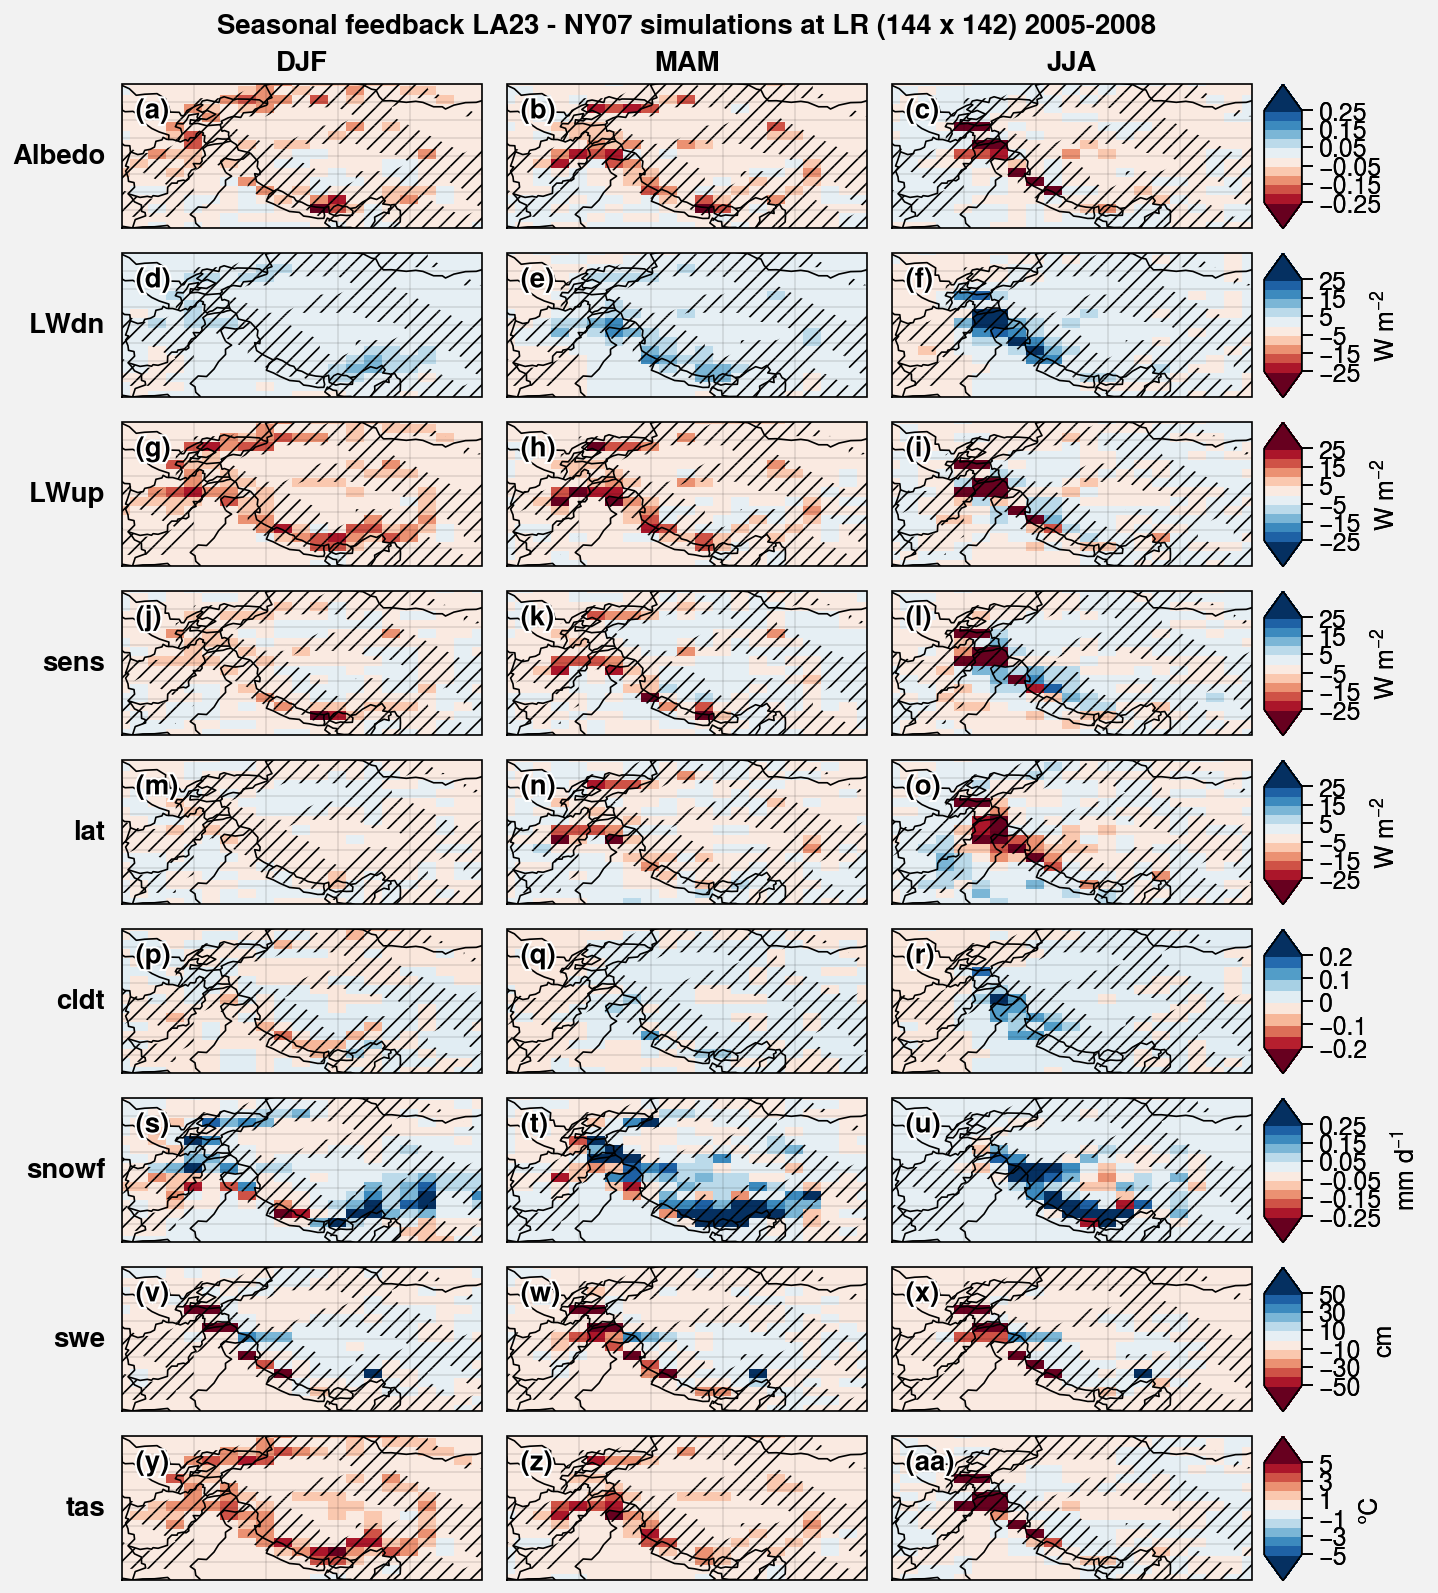

In [14]:
fig, axs = plot.subplots(ncols = 3, nrows = len(labels), proj='cyl', axwidth=1.8)

extend_bias = 'both'

threshold = 200 # STD
seasons = ['DJF', 'MAM', 'JJA']

k = 0
for var, label, unit in zip(list_var, labels, units):
    if label in ['Albedo', 'snowf']:
        levels_bias = plot.arange(-0.25, 0.25, 0.05)
    elif label in ['LWdn', 'LWup', 'sens', 'lat']:
        levels_bias = plot.arange(-25, 25, 5)
    elif label in ['cldt']:
        levels_bias = plot.arange(-0.2, 0.20, 0.05)
    elif label in ['swe']:
        levels_bias = plot.arange(-50, 50, 10)
    elif label in ['tas']:
        levels_bias = plot.arange(-5, 5, 1)
        
    if label in ['Albedo', 'LWdn', 'sens', 'lat', 'cldt', 'swe', 'snowf']:
        cmap_bias = 'RdBu'
    else:
        cmap_bias = 'RdBu_r'
        
    for season in seasons:
        m = axs[k].pcolormesh(var.sel(lat=latlim_HMA, lon=lonlim_HMA, season=season), cmap=cmap_bias, levels=levels_bias, extend=extend_bias, rasterized=True)
        k += 1
    axs[k-1].colorbar(m, label=unit)
    
for ax in axs:
    ax.contourf(std_LR_regrid.where(std_LR_regrid > threshold), hatches=['////'], alpha=0)

# fig.colorbar(m, label='cldtall [-]', row=1, ticks=levels)
# fig.colorbar(m_bias, label='Difference of cldtall (model - obs) [-]', rows=(2,4), length=0.9)

axs.format(
    latlim=(25, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    collabels = seasons,
    rowlabels = labels,
    borders=True, coast=True, labels=False, 
    abc=True, abcloc='ul',
    suptitle='Seasonal feedback LA23 - NY07 simulations at LR (144 x 142) '+str(period.start)+'-'+str(period.stop) 
)

for ext in ['jpg', 'pdf']:
    fig.save('img/fig11.'+ext)

## Relative

In [9]:
labels = ['Albedo', 'LWdn', 'LWup', 'sens', 'lat', 'cldt', 'snowf', 'swe', 'tas']
units = ['%']*len(labels)

list_var = [
    ((SWupSFC_LA22/SWdnSFC_LA22 - SWupSFC_NY07/SWdnSFC_NY07)/np.abs((SWupSFC_NY07/SWdnSFC_NY07))*100).groupby('time.season').mean('time'),
    ((LWdnSFC_LA22 - LWdnSFC_NY07)/np.abs(LWdnSFC_NY07)*100).groupby('time.season').mean('time'),
    ((LWupSFC_LA22 - LWupSFC_NY07)/np.abs(LWupSFC_NY07)*100).groupby('time.season').mean('time'),
    ((sens_LA22 - sens_NY07)/np.abs(sens_NY07)*100).groupby('time.season').mean('time'),
    ((lat_ter_LA22 - lat_ter_NY07)/np.abs(lat_ter_NY07)*100).groupby('time.season').mean('time'),
    ((cldt_LA22 - cldt_NY07)/np.abs(cldt_NY07)*100).groupby('time.season').mean('time'),
    ((snowf_LA22 - snowf_NY07)/np.abs(snowf_NY07)*100).groupby('time.season').mean('time'),
    ((swe_LA22 - swe_NY07)/np.abs(swe_NY07)*100).groupby('time.season').mean('time'),
    ((tas_LA22 - tas_NY07)/np.abs((tas_NY07+273.15))*100).groupby('time.season').mean('time'),
]

latlim, lonlim = u.get_domain_HMA()

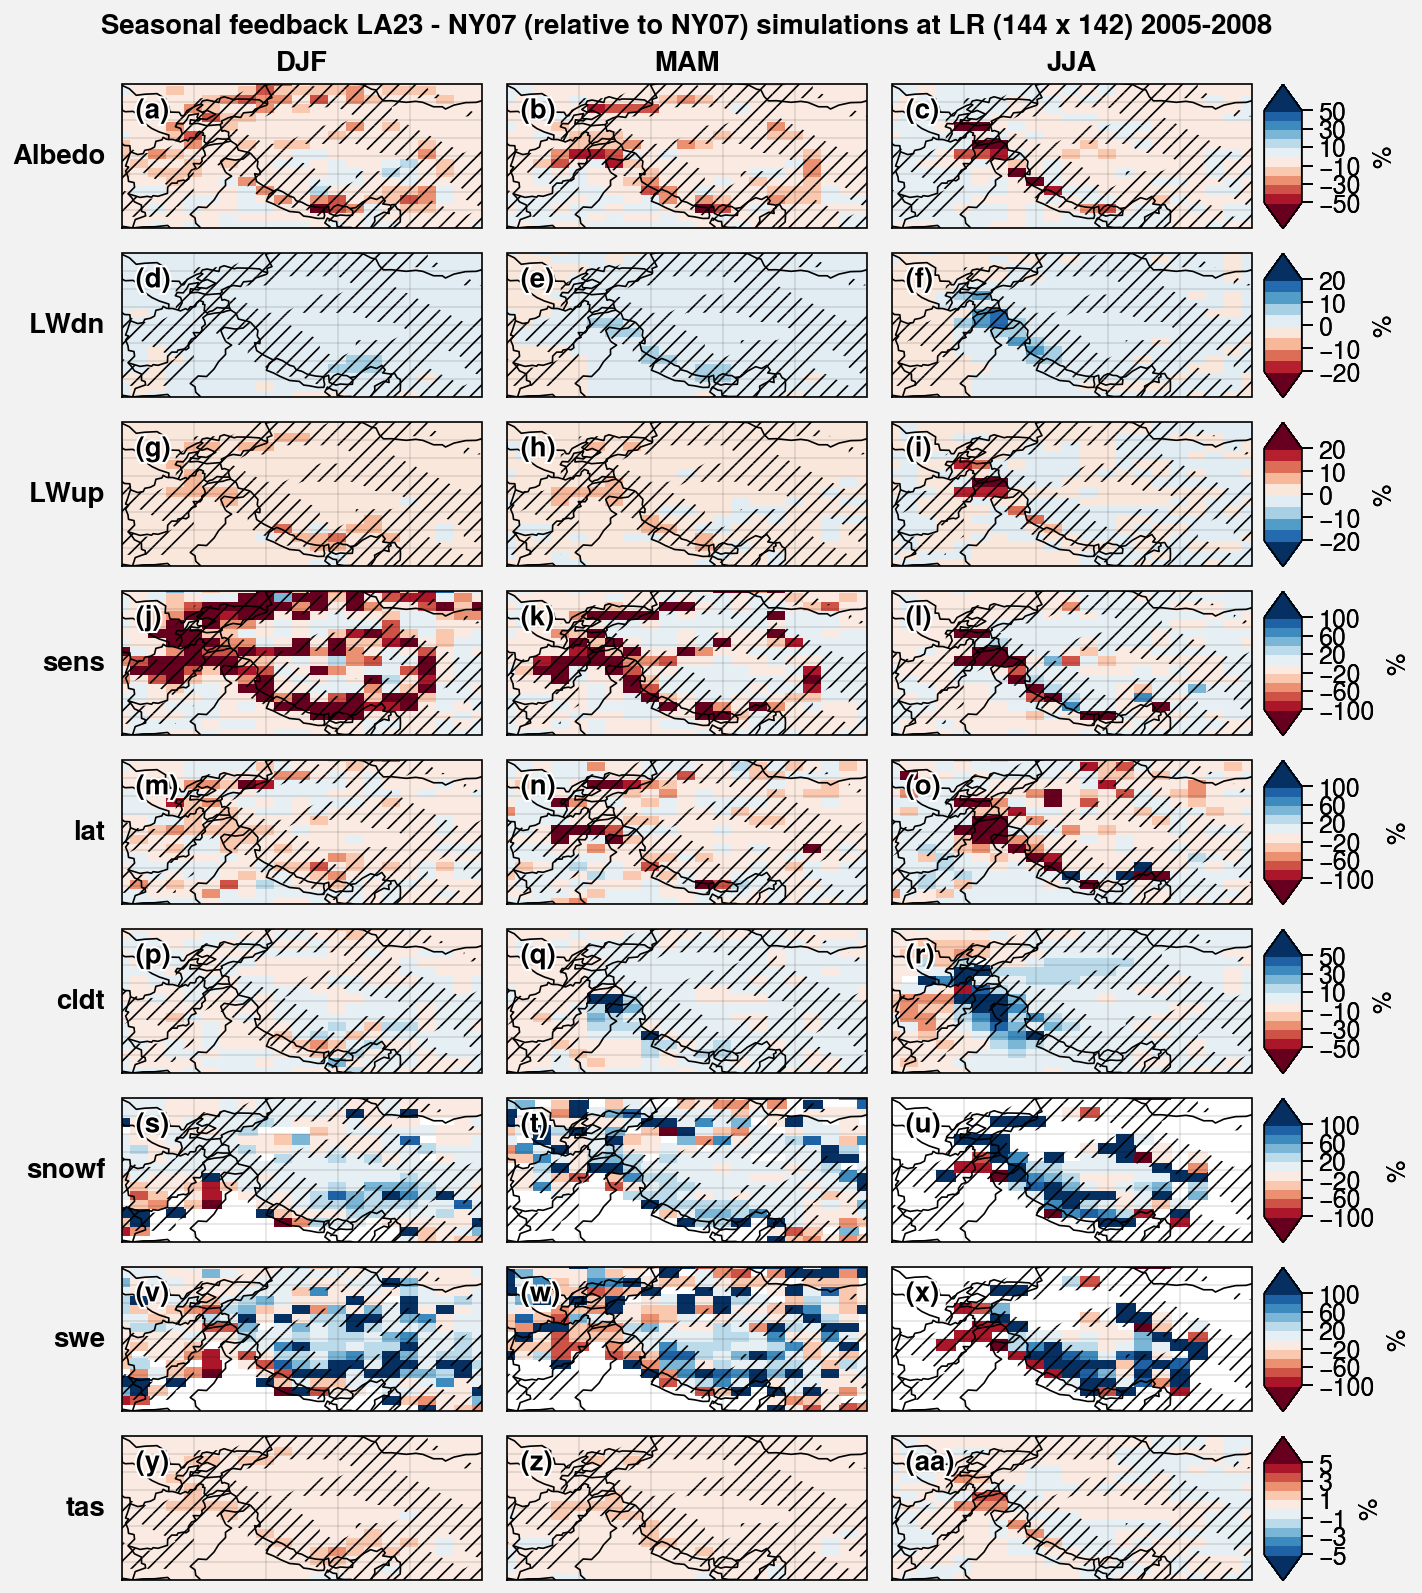

In [11]:
fig, axs = plot.subplots(ncols = 3, nrows = len(labels), proj='cyl', axwidth=1.8)

extend_bias = 'both'

threshold = 200 # STD
seasons = ['DJF', 'MAM', 'JJA']

k = 0
for var, label, unit in zip(list_var, labels, units): 
    if label in ['LWdn', 'LWup']:
        levels_bias = plot.arange(-20, 20, 5)
    elif label in ['sens', 'lat', 'snowf', 'swe']:
        levels_bias = plot.arange(-100, 100, 20)
    elif label in ['tas']:
        levels_bias = plot.arange(-5, 5, 1)
    else:
        levels_bias = plot.arange(-50, 50, 10)
        
    if label in ['Albedo', 'LWdn', 'sens', 'lat', 'cldt', 'swe', 'snowf']:
        cmap_bias = 'RdBu'
    else:
        cmap_bias = 'RdBu_r'
        
    for season in seasons:
        m = axs[k].pcolormesh(var.sel(lat=latlim_HMA, lon=lonlim_HMA, season=season), cmap=cmap_bias, levels=levels_bias, extend=extend_bias, rasterized=True)
        k += 1
    axs[k-1].colorbar(m, label=unit)
    
for ax in axs:
    ax.contourf(std_LR_regrid.where(std_LR_regrid > threshold), hatches=['////'], alpha=0)

# fig.colorbar(m, label='cldtall [-]', row=1, ticks=levels)
# fig.colorbar(m_bias, label='Difference of cldtall (model - obs) [-]', rows=(2,4), length=0.9)

axs.format(
    latlim=(25, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    collabels = seasons,
    rowlabels = labels,
    borders=True, coast=True, labels=False, 
    abc=True, abcloc='ul',
    suptitle='Seasonal feedback LA23 - NY07 (relative to NY07) simulations at LR (144 x 142) '+str(period.start)+'-'+str(period.stop) 
)

for ext in ['jpg', 'pdf']:
    fig.save('img/figB2.'+ext)

## Absolute values

In [12]:
labels = ['Albedo', 'LWdn', 'LWup', 'sens', 'lat', 'cldt', 'snowf', 'swe', 'tas']
units = ['', 'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', '', 'mm d$^{-1}$', 'cm', '°C']

list_var = [
    (SWupSFC_NY07/SWdnSFC_NY07).groupby('time.season').mean('time'),
    LWdnSFC_NY07.groupby('time.season').mean('time'),
    LWupSFC_NY07.groupby('time.season').mean('time'),
    sens_NY07.groupby('time.season').mean('time'),
    lat_ter_NY07.groupby('time.season').mean('time'),
    cldt_NY07.groupby('time.season').mean('time'),
    snowf_NY07.groupby('time.season').mean('time'),
    swe_NY07.groupby('time.season').mean('time'),
    tas_NY07.groupby('time.season').mean('time'),
]

latlim, lonlim = u.get_domain_HMA()

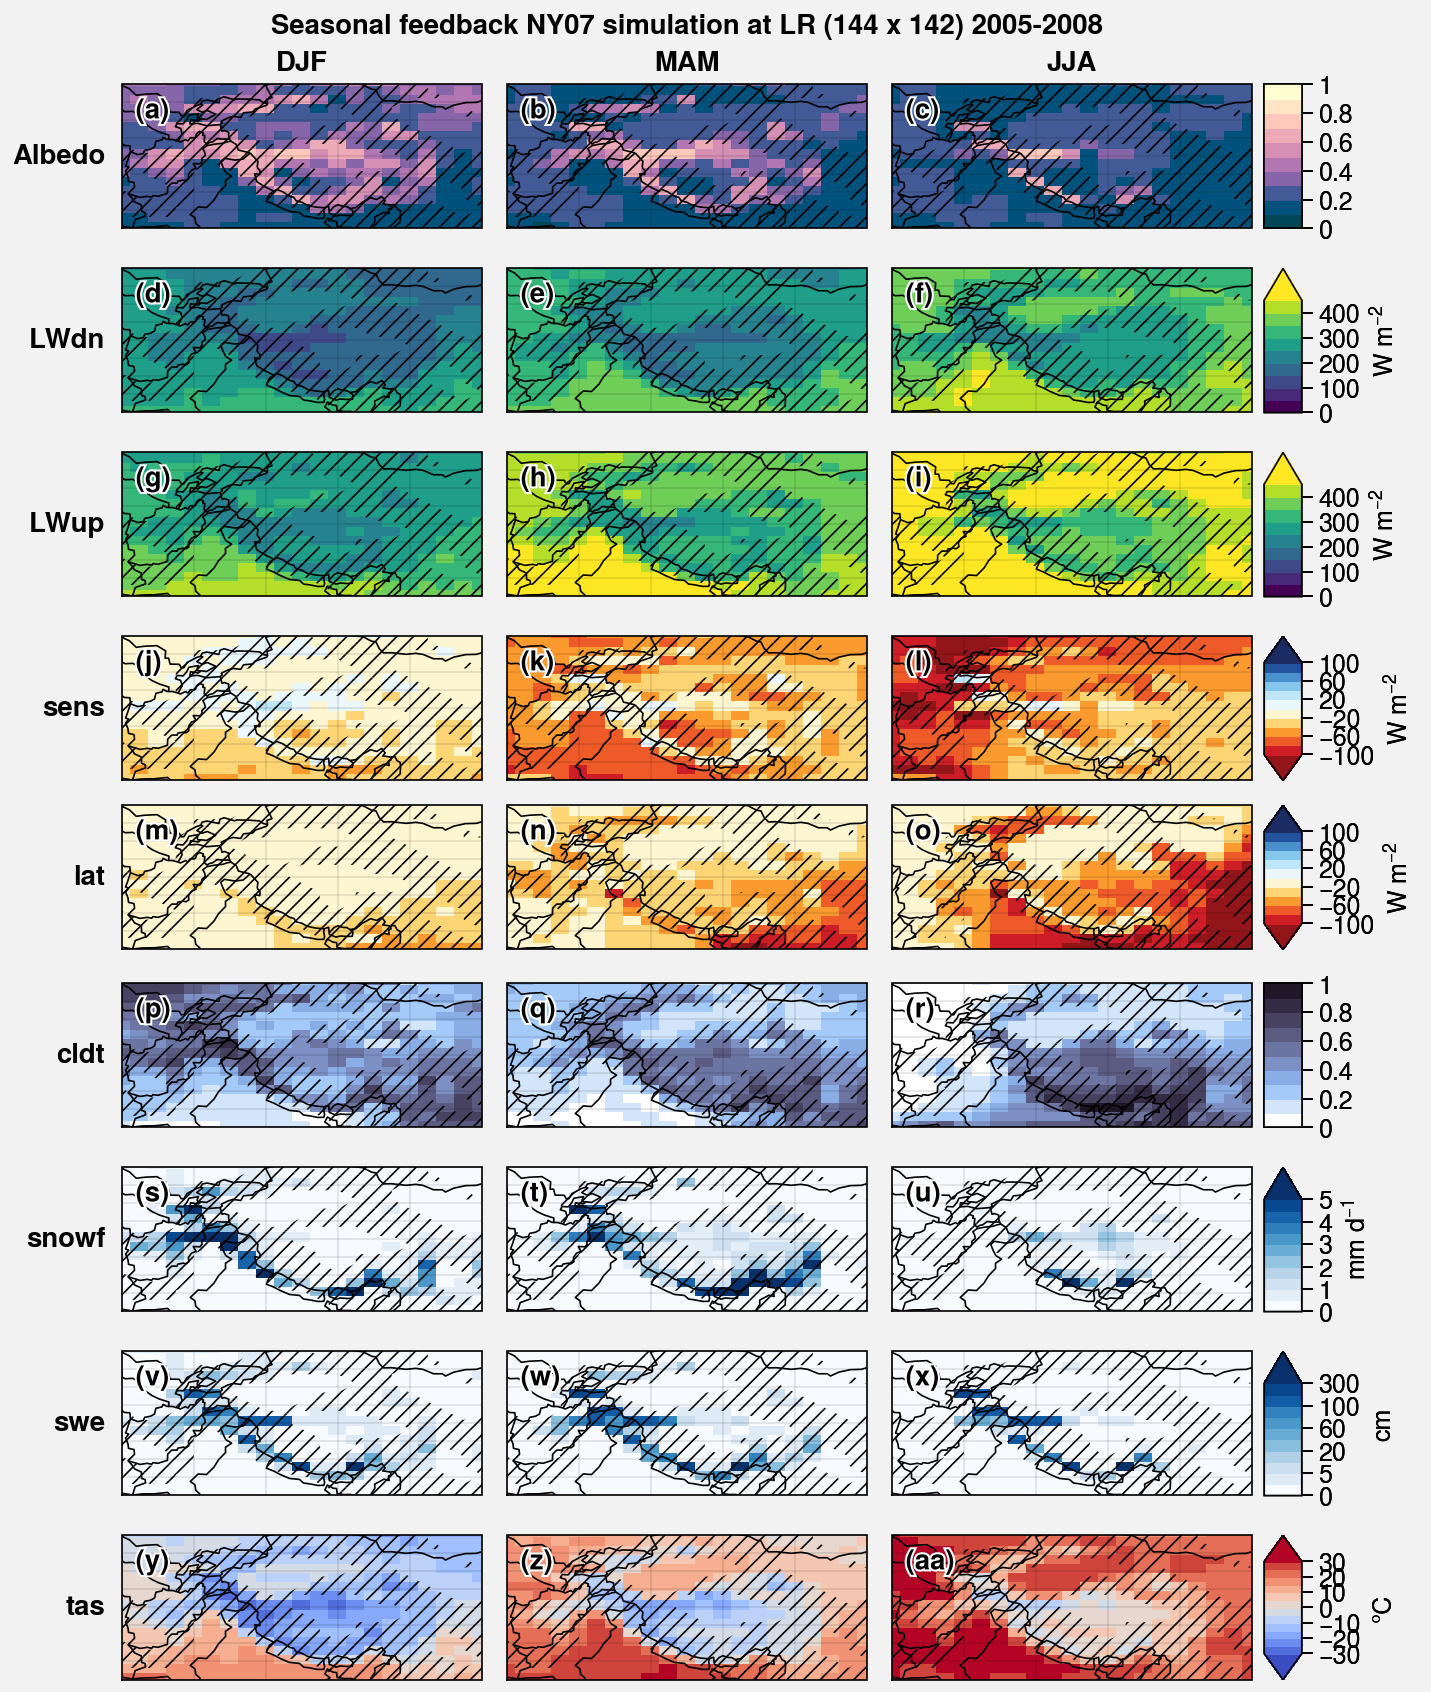

In [13]:
fig, axs = plot.subplots(ncols = 3, nrows = len(labels), proj='cyl', axwidth=1.8)

threshold = 200 # STD
seasons = ['DJF', 'MAM', 'JJA']

k = 0
for var, label, unit in zip(list_var, labels, units):
    if label in ['Albedo']:
        cmap = 'Sunrise_r'; levels = plot.arange(0, 1, 0.1); extend = 'neither'
    elif label in ['LWdn', 'LWup']:
        cmap = 'viridis'; levels = plot.arange(0, 450, 50); extend = 'max'
    elif label in ['sens']:
        cmap = 'ColdHot_r'; levels = plot.arange(-100, 100, 20); extend = 'both'
    elif label in ['lat']:
        cmap = 'ColdHot_r'; levels = plot.arange(-100, 100, 20); extend = 'both'
    elif label in ['cldt']:
        cmap = 'Dusk'; levels = plot.arange(0, 1, 0.1); extend = 'neither'
    elif label in ['swe']:
        levels = [0, 1, 5, 10, 20, 40, 60, 80 ,100 ,200, 300]; extend = 'max'; cmap = 'Blues'
    elif label in ['snowf']:
        cmap = 'Blues'; levels = plot.arange(0, 5, 0.5); extend = 'max'
    elif label in ['tas']:
        levels = plot.arange(-30, 30, 5); cmap = 'CoolWarm'; extend = 'both'
        
    for season in seasons:
        m = axs[k].pcolormesh(var.sel(lat=latlim_HMA, lon=lonlim_HMA, season=season), cmap=cmap, levels=levels, extend=extend, rasterized=True)
        k += 1
    axs[k-1].colorbar(m, label=unit)
    
for ax in axs:
    ax.contourf(std_LR_regrid.where(std_LR_regrid > threshold), hatches=['////'], alpha=0)

# fig.colorbar(m, label='cldtall [-]', row=1, ticks=levels)
# fig.colorbar(m_bias, label='Difference of cldtall (model - obs) [-]', rows=(2,4), length=0.9)

axs.format(
    latlim=(25, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    collabels = seasons,
    rowlabels = labels,
    borders=True, coast=True, labels=False, 
    abc=True, abcloc='ul',
    suptitle='Seasonal feedback NY07 simulation at LR (144 x 142) '+str(period.start)+'-'+str(period.stop) 
)

for ext in ['jpg', 'pdf']:
    fig.save('img/figB1.'+ext)